## VGG16 
### DATASET : FER2013

In [1]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

**Setup**

In [2]:
from skimage import io
import os, random

from keras.preprocessing import image
import keras.utils as image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

**Importing the data**

In [3]:
import os
print(os.listdir('../dataset/FER2013/'))

['.DS_Store', 'test', 'train']


In [4]:
train_dir = '../dataset/FER2013/train/'
test_dir  = '../dataset/FER2013/test/'

**Analyzing the dataset**

In [5]:
labels = sorted(os.listdir(train_dir))
print(labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


**Data Augmentation**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [7]:
batch_size = 64
target_size = (48,48)

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 10,
                                   width_shift_range = 0.2, height_shift_range = 0.2, 
                                   zoom_range = 0.2, horizontal_flip = True)

test_datagen  = ImageDataGenerator(rescale = 1./255, rotation_range = 10,
                                   width_shift_range = 0.2, height_shift_range = 0.2, 
                                   zoom_range = 0.2, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = target_size,
                  batch_size = batch_size, color_mode = "grayscale",
                  class_mode = 'categorical', shuffle = True)

test_generator = test_datagen.flow_from_directory(test_dir, target_size = target_size,
                 batch_size = batch_size, color_mode = "grayscale",
                 class_mode = 'categorical', shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Build Model**

In [8]:
input_shape = (48,48,1) # img_rows, img_colums, color_channels
num_classes = len(labels) # 7

In [9]:
import keras
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import (Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Concatenate, LeakyReLU, BatchNormalization, concatenate)

In [10]:
#EVALUATION

import keras.backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
#EVALUATION

METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),  
           tf.keras.metrics.AUC(name='auc'), f1_score]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-01 16:24:56.956866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 16:24:56.957387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model = models.Sequential()

model.add(Conv2D(64, (3, 3), input_shape = input_shape, activation = 'relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
    
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = METRICS) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       1

In [13]:
num_epochs = 30
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

**Training the model**

In [14]:
history = model.fit(train_generator, steps_per_epoch = step_size_train, epochs = num_epochs, verbose = 1,
                    validation_data = test_generator, validation_steps = step_size_test)

Epoch 1/30


2023-02-01 16:24:57.679926: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-01 16:24:59.057608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 1.8646 - accuracy: 0.8556 - precision: 0.2245 - recall: 0.0043 - auc: 0.6364 - f1_score: 0.0082

2023-02-01 16:27:52.510188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 189s 408ms/step - loss: 1.8646 - accuracy: 0.8556 - precision: 0.2245 - recall: 0.0043 - auc: 0.6364 - f1_score: 0.0082 - val_loss: 1.8630 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6309 - val_f1_score: 0.0000e+00
Epoch 2/30
448/448 [==============================] - 177s 396ms/step - loss: 1.8173 - accuracy: 0.8566 - precision: 0.2000 - recall: 0.0014 - auc: 0.6546 - f1_score: 0.0027 - val_loss: 1.8392 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 1.3951e-04 - val_auc: 0.6503 - val_f1_score: 2.7473e-04
Epoch 3/30
448/448 [==============================] - 178s 396ms/step - loss: 1.7591 - accuracy: 0.8575 - precision: 0.5501 - recall: 0.0136 - auc: 0.6865 - f1_score: 0.0260 - val_loss: 1.7797 - val_accuracy: 0.8572 - val_precision: 0.6667 - val_recall: 8.3705e-04 - val_auc: 0.6821 - val_f1_score: 0.0016
Epoch 4/30
448/448 [==============================] - 179s 399ms/step - loss: 1.6

In [15]:
# Save Model
models.save_model(model, 'fer2013_vgg16.h5')

**Plotting accuracy and loss**

<Figure size 640x480 with 0 Axes>

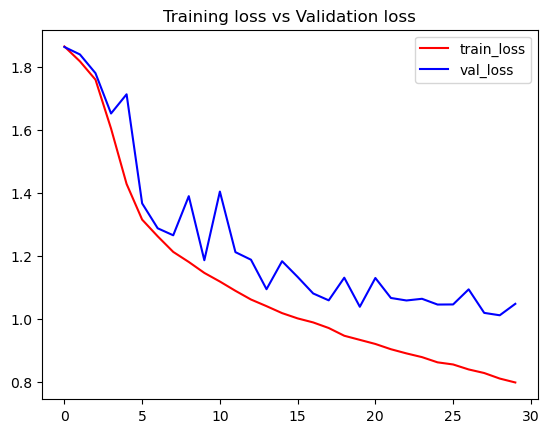

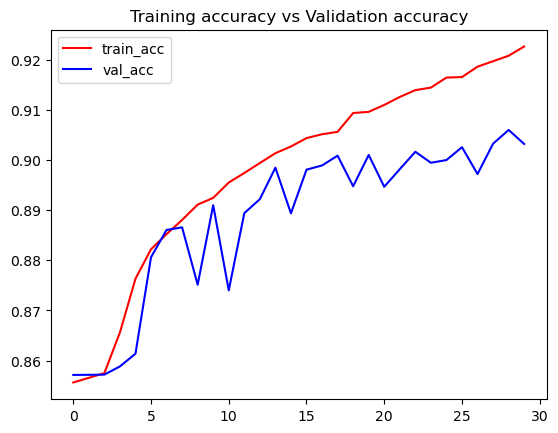

<Figure size 640x480 with 0 Axes>

In [16]:
# visualizing losses and accuracy
%matplotlib inline

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label = 'train_loss')
plt.plot(epochs,val_loss,'b', label = 'val_loss')
plt.title('Training loss vs Validation loss')
plt.legend()
plt.savefig('trainloss.png')
plt.figure()

plt.plot(epochs,train_acc,'r', label = 'train_acc')
plt.plot(epochs,val_acc,'b', label = 'val_acc')
plt.title('Training accuracy vs Validation accuracy')
plt.legend()
plt.savefig('trainacc.png')
plt.figure()

# Quantitative Prediction

**Accuracy and Loss**

In [23]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

In [27]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.92
Train Loss:  0.8
Train Precision:  0.8
Train Recall:  0.62
Train F1-Score:  0.69


In [28]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.9
Test Loss:  1.05
Test Precision:  0.73
Test Recall:  0.52
Test F1-Score:  0.59


**Confusion Matrix**

In [17]:
# Evaluate model on test set
acc = model.evaluate(test_generator, steps = step_size_test)
print ("model %s: %.2f%%" % (model.metrics_names[1], acc[1]*100))

112/112 [==============================] - 10s 92ms/step - loss: 1.0394 - accuracy: 0.9024 - precision: 0.7187 - recall: 0.5204 - auc: 0.9111 - f1_score: 0.5925
model accuracy: 90.24%


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.metrics import categorical_accuracy

In [40]:
import seaborn as sns

In [44]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
y_true = test_generator.classes
y_hat =  model.predict(test_generator)
y_hat = tf.argmax(y_hat, axis = 1).numpy()
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

113/113 [==============================] - 13s 116ms/step


Confusion matrix, without normalization
[[ 606   12   96   32   73  128   11]
 [  45   41    7    2    2   12    2]
 [ 176    7  365   44   86  260   86]
 [  73    0   37 1477   84   76   27]
 [ 123    0   48   73  741  234   14]
 [ 168    5  125   44  209  686   10]
 [  62    1  101   52   35   15  565]]


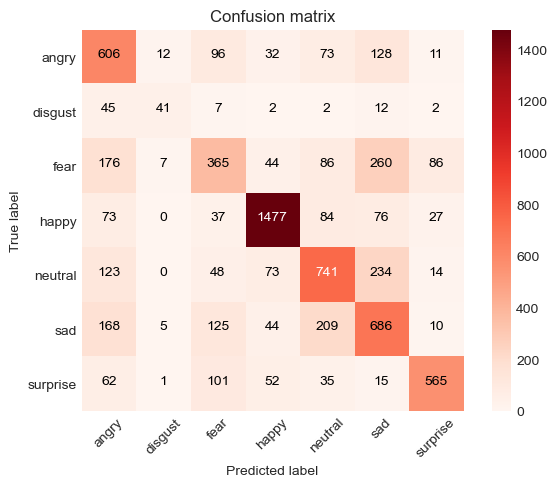

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')

# Qualitative Prediction

1/1 [==============================] - 0s 105ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


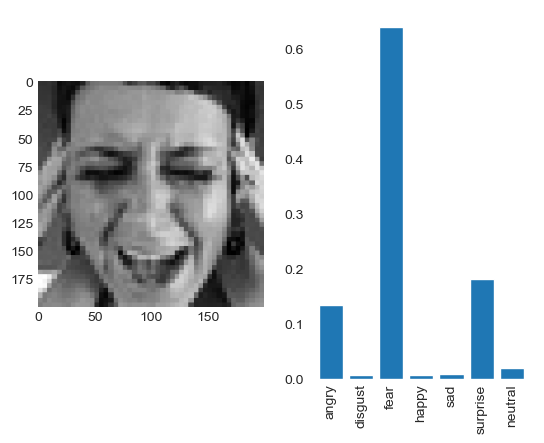

Expression Prediction: fear
1/1 [==============================] - 0s 26ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


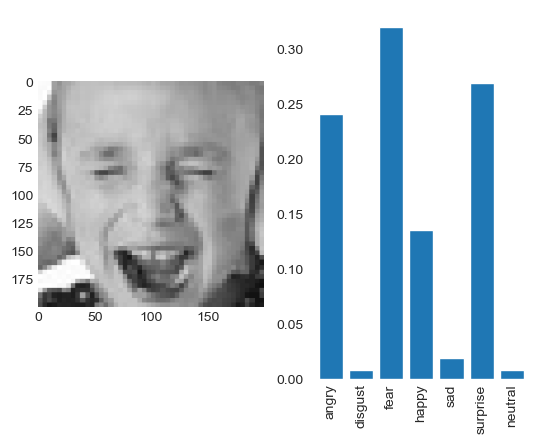

Expression Prediction: fear
1/1 [==============================] - 0s 18ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


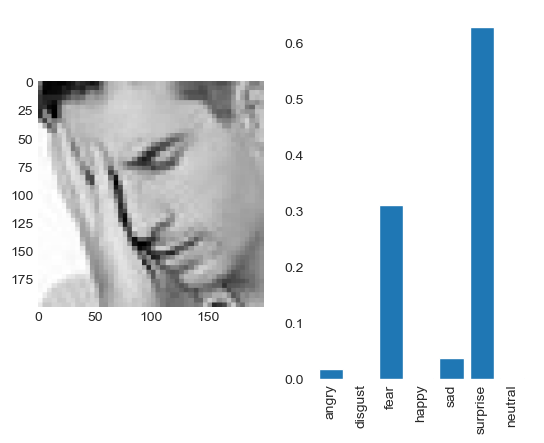

Expression Prediction: surprise
1/1 [==============================] - 0s 19ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


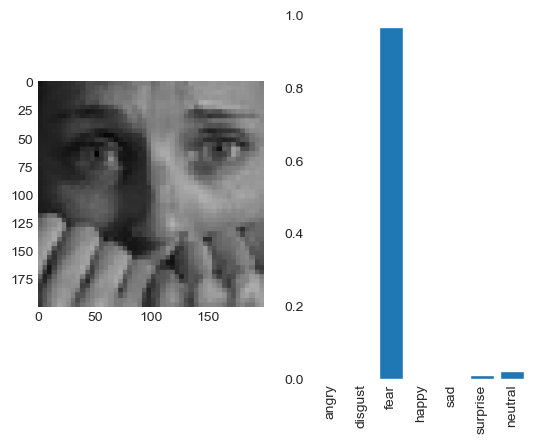

Expression Prediction: fear
1/1 [==============================] - 0s 23ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


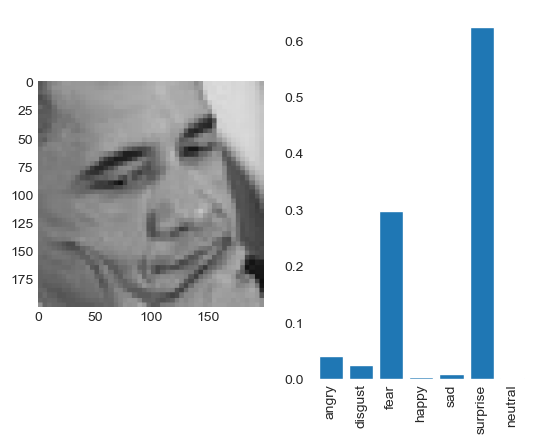

Expression Prediction: surprise
1/1 [==============================] - 0s 20ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


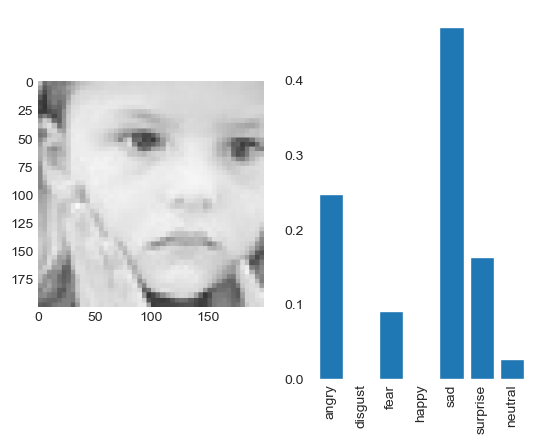

Expression Prediction: sad
1/1 [==============================] - 0s 30ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


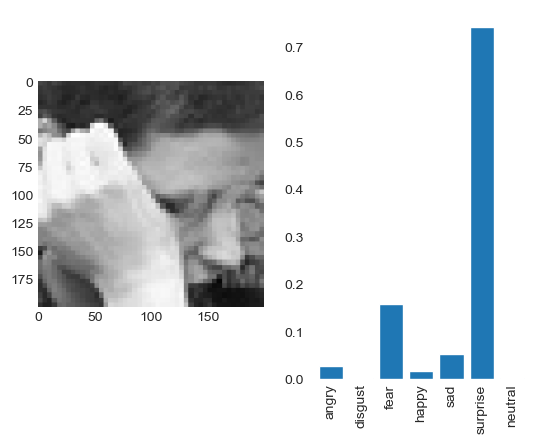

Expression Prediction: surprise
1/1 [==============================] - 0s 30ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


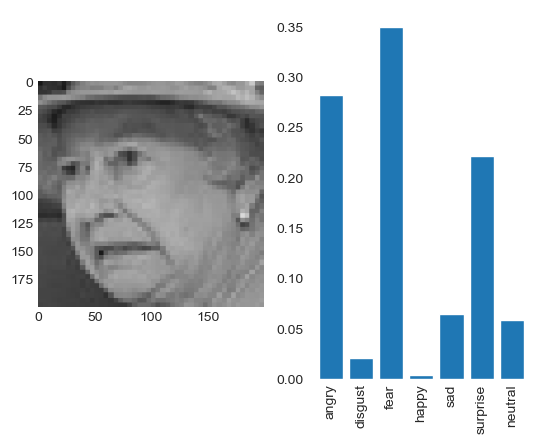

Expression Prediction: fear
1/1 [==============================] - 0s 19ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


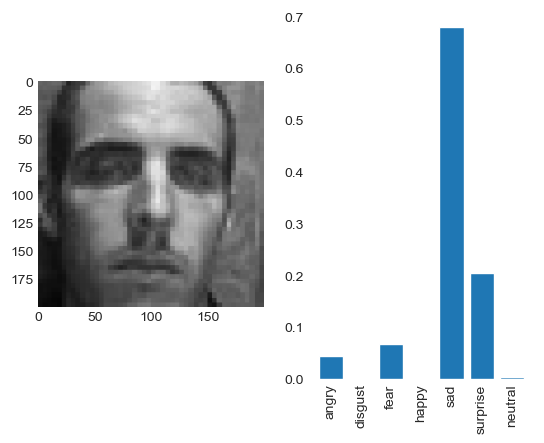

Expression Prediction: sad
1/1 [==============================] - 0s 19ms/step


/Users/hanirosman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


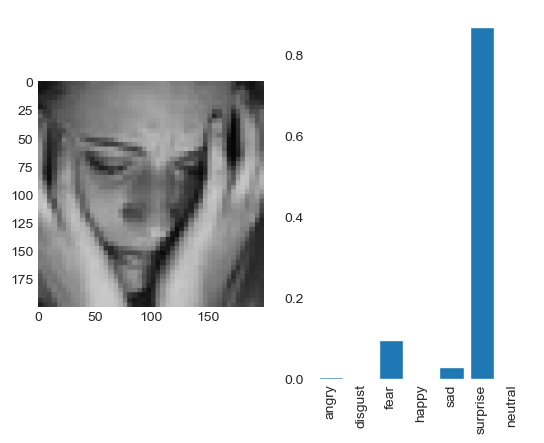

Expression Prediction: surprise


In [37]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
for i in range(0, 10):
    randimg = random.choice(os.listdir("../dataset/FER2013/test/fear/"))
    randimgpath = "../dataset/FER2013/test/fear/" + randimg
    img = image.load_img(randimgpath, grayscale = True, target_size = (48, 48))
    show_img = image.load_img(randimgpath, grayscale = False, target_size = (200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(show_img)
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a = custom[0]
    m = a[0]
    for i in range(0,len(a)):
        if a[i] >= m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])